# Подготовка

In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections

In [2]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)

    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

In [3]:
# Делим на 2 равные группы
def groups_splitter(df, columns, user_salt=None):

    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

# Загрузка данных

In [8]:
import requests

# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [9]:
# Распаковываем архив из 3 файлов
import zipfile

with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

In [7]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)

In [8]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(min_date, max_date)

2021-03-13 2021-08-22


# Дизайн А/В теста

❓Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

In [9]:
week = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]
week = week.groupby('user_id', as_index=False).agg({'total_dur': sum})

/var/folders/qq/_jkh81gs4rs_z1jwm1d48dyc0000gp/T/ipykernel_2809/3072904357.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  week = week.groupby('user_id', as_index=False).agg({'total_dur': sum})


## Бутстреп и нелогарифмированная метрика

### Корректность

❓Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю

In [10]:
NUM_ITERS = 1000 # !!! Все считаем на 1000 итерациях

In [11]:
def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue
    
def bootstrap_test(vec_a, vec_b):
    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
    dif = sample_a_mean - sample_b_mean
    left_side, right_side = np.percentile(dif,
                                        [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])
    return bool(not left_side <= 0 <= right_side), get_p_value(sample_a_mean - sample_b_mean)

In [12]:
def count_power(df, test_func, effect, metric="total_dur", num_iters=NUM_ITERS):
    if effect > 1:
        effect = effect / 100
    power = []

    for i in tqdm(range(num_iters)):
        new_df = groups_splitter(df.copy(), columns=['user_id', metric, 'group'], user_salt=salt_generator()).drop_duplicates()

        vec_a = new_df[new_df['group'] == 'A'][metric]
        if "ln" in metric:
            vec_b = new_df[new_df['group'] == 'B'][metric] + np.log2(1 + effect)
        else:
            vec_b = new_df[new_df['group'] == 'B'][metric] * (1 + effect)

        power.append(test_func(vec_a, vec_b)[0])

        test_power = collections.Counter(power)

    power = test_power[True] / (test_power[True] + test_power[False])
    return power

In [13]:
def count_correctness(df, test_func, metric="total_dur", num_iters=NUM_ITERS):
    values = []
    correctness = []

    for i in tqdm(range(num_iters)):
        new_df = groups_splitter(df.copy(), columns=['user_id', metric, 'group'], user_salt=salt_generator()).drop_duplicates()

        vec_a = new_df[new_df['group'] == 'A'][metric]
        vec_b = new_df[new_df['group'] == 'B'][metric]

        correct, value = test_func(vec_a, vec_b)
        correctness.append(correct)
        values.append(value)

        test_correctness = collections.Counter(correctness)
        
    plt.hist(values, bins=10, color='purple');
    plt.title(f"Бутстреп распределение p_value")

    return test_correctness[True] / (test_correctness[True] + test_correctness[False])

In [ ]:
correctness = count_correctness(week, bootstrap_test)
print(f'Correctness: {correctness}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Correctness: 0.06


  0%|          | 0/1000 [00:00<?, ?it/s]

Correctness: 0.041


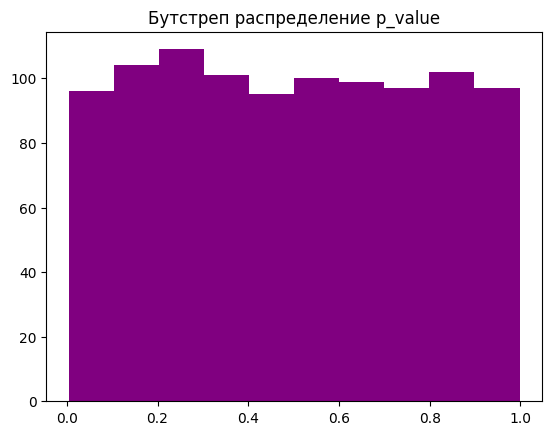

In [66]:
correctness = count_correctness(week, bootstrap_test)
print(f'Correctness: {correctness}')

❗️На семинаре (1 неделя, 50 итераций): 0.02 (98%)

В ДЗ (2 недели, 1000 итераций): 0.04 (96%)

Вывод: тест стал чаще детектировать значимые отклонения там, где их нет. Можно предположить, что с увеличением числа данных увеличилось количество выбросов. Но если посмотреть на распределение p-values, увидим, что оно стало более равномерным, значит стабильность теста все-таки повысилась. Поэтому значение 0.04 лучше отражает реальную ошибку первого рода.

### Мощность

❓На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (3 балла за расчет + 2 балла за подроброе объяснение)

In [ ]:
effect=0.01
power = count_power(week, bootstrap_test, effect=effect)
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.01
Power: 0.104


❗️При добавлении эффекта в 1%, значимые отклонения детектируются тестом только в 10% случаев. Это очень низкий уровень мощности.

In [ ]:
effect=0.03
power = count_power(week, bootstrap_test, effect=effect)
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.03
Power: 0.639


❗️При добавлении эффекта в 3%, значимые отклонения детектируются тестом уже в 64% случаев. Небольшое измение эффекта значительно повысило мощность.

In [ ]:
effect=0.05
power = count_power(week, bootstrap_test, effect=effect)
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.05
Power: 0.967


❗️При добавлении эффекта в 5%, значимые отклонения детектируются тестом уже в 97% случаев. Значит для выявление отклонений на 5% и больше тесту можно доверять.

### MDE

❓Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (3 балла)

In [61]:
from scipy.stats import norm

def get_mde(metric_vec, alpha=0.05, beta=0.2):
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()
    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    return mde*100/metric_mean

In [62]:
get_mde(week['total_dur'], alpha=0.04, beta=0.03)

2.5344100141456107

❗️Возьмем ошибку второго рода в 0.04 (она получена для эффекта в 5%). Получаем MDE около 2%.

❓Посчитать аналогичный дизайн для:
- бутстреп + логарифмированная метрика длительности просмотров (4 балла)
- манна-уитни + метрика длительности просмотров (4 балла)
- манна-уитни + логарифмированная метрика длительности просмотров (4 балла)
- t-test + метрика длительности просмотров (4 балла)
- t-test + логарифмированная метрика длительности просмотров (4 балла)

## бутстреп + логарифмированная метрика длительности просмотров (4 балла)

❗️Логарифмируем метрику просмотров, чтобы снизить дисперсию и приблизить распределение к нормальному.

In [20]:
week['total_dur_ln'] = np.log2(week['total_dur'])

  0%|          | 0/1000 [00:00<?, ?it/s]

Correctness: 0.045


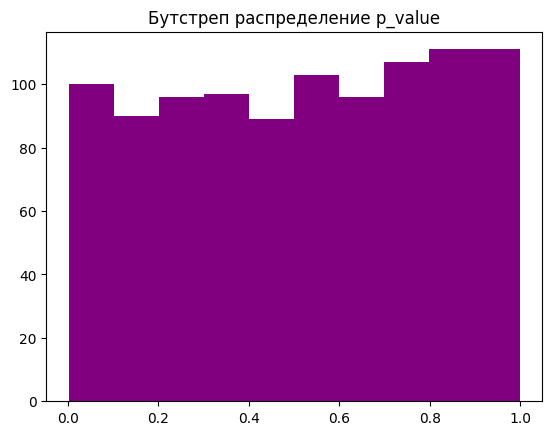

In [16]:
correctness = count_correctness(week, bootstrap_test, metric='total_dur_ln')
print(f'Correctness: {correctness}')

❗️Корректность 96%: в 96% тест не нашел отклонения там, где их нет. Распределение p-values менее равномерное, чем для нелогарифмированной метрик.

In [23]:
effect=0.01
power = count_power(week, bootstrap_test, effect=effect, metric='total_dur_ln')
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.01
Power: 0.183


In [24]:
effect=0.03
power = count_power(week, bootstrap_test, effect=effect, metric='total_dur_ln')
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.03
Power: 0.884


In [25]:
effect=0.05
power = count_power(week, bootstrap_test, effect=effect, metric='total_dur_ln')
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.05
Power: 0.998


❗️Мощность выше чем для таких же эффектов для нелогарифмированной метрики.

In [63]:
get_mde(week['total_dur'], alpha=0.05, beta=0.01)

2.7609999501284936

## манна-уитни + метрика длительности просмотров (4 балла)

In [15]:
from scipy.stats import mannwhitneyu

def mannwhitneyu_test(vec_a, vec_b):
    _, p = mannwhitneyu(vec_a, vec_b)
    return bool(p < 0.05), p

  0%|          | 0/1000 [00:00<?, ?it/s]

Correctness: 0.045


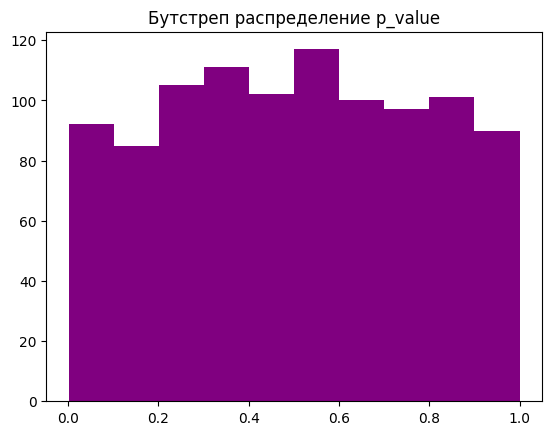

In [49]:
correctness = count_correctness(week, mannwhitneyu_test, num_iters=1000, metric='total_dur')
print(f'Correctness: {correctness}')

❗️Корректность 95%: в 95% тест не нашел отклонения там, где их нет. Такая же как для бутстрепа с нелогарифмированной метрикой. Распределение p-values менее равномерное, чем для бутстрепа.

In [16]:
effect=0.01
power = count_power(week, mannwhitneyu_test, effect=effect)
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.01
Power: 0.246


In [17]:
effect=0.03
power = count_power(week, mannwhitneyu_test, effect=effect)
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.03
Power: 0.958


In [18]:
effect=0.05
power = count_power(week, mannwhitneyu_test, effect=effect)
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.05
Power: 1.0


In [66]:
get_mde(week['total_dur'], alpha=0.05, beta=0)

inf

❗️Мощность выше чем для таких же эффектов для бутстрепа.

## манна-уитни + логарифмированная метрика длительности просмотров (4 балла)

  0%|          | 0/1000 [00:00<?, ?it/s]

Correctness: 0.052


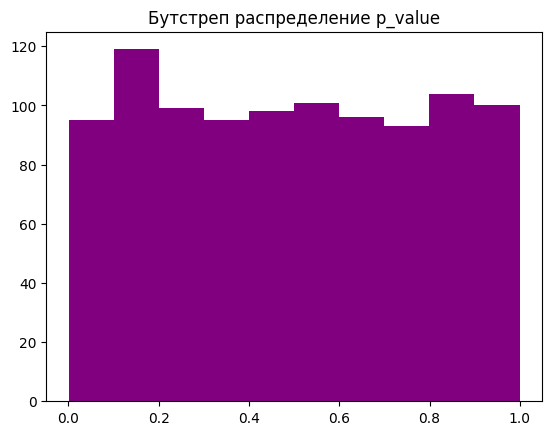

In [51]:
correctness = count_correctness(week, mannwhitneyu_test, metric='total_dur_ln')
print(f'Correctness: {correctness}')

❗️Корректность 95%: в 95% тест не нашел отклонения там, где их нет. Распределение p-values менее равномерное, чем для логарифмированной метрики.

In [34]:
effect=0.01
power = count_power(week, mannwhitneyu_test, effect=effect, metric='total_dur_ln')
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.01
Power: 0.244


In [21]:
effect=0.03
power = count_power(week, mannwhitneyu_test, effect=effect, metric='total_dur_ln')
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.03
Power: 0.961


In [22]:
effect=0.05
power = count_power(week, mannwhitneyu_test, effect=effect, metric='total_dur_ln')
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.05
Power: 1.0


❗️Мощность 100%: тест всегда обнаруживает эффект, если он действительно существует.

In [67]:
get_mde(week['total_dur'], alpha=0.05, beta=0)

inf

## t-test + метрика длительности просмотров (4 балла)

In [19]:
from scipy.stats import ttest_ind

def ttest_test(vec_a, vec_b):
    _, p = ttest_ind(vec_a, vec_b)
    return bool(p < 0.05), p

  0%|          | 0/1000 [00:00<?, ?it/s]

Correctness: 0.053


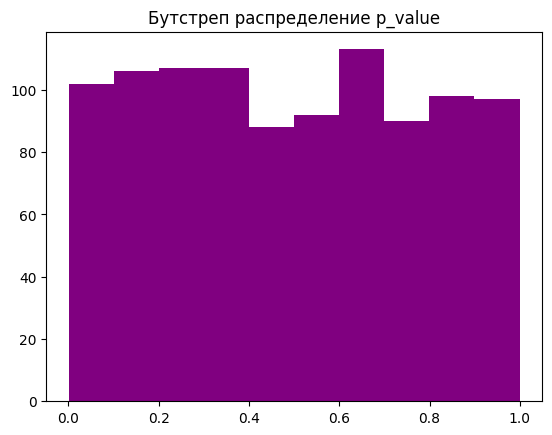

In [55]:
correctness = count_correctness(week, ttest_test, metric='total_dur')
print(f'Correctness: {correctness}')

❗️Корректность 95%: в 95% тест не нашел отклонения там, где их нет. Распределение p-values менее равномерное, чем для других тестов.

In [31]:
effect=0.01
power = count_power(week, ttest_test, effect=effect)
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.01
Power: 0.124


In [32]:
effect=0.03
power = count_power(week, ttest_test, effect=effect)
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.03
Power: 0.593


In [33]:
effect=0.05
power = count_power(week, ttest_test, effect=effect)
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.05
Power: 0.978


❗️Мощность 98%: тест обнаруживает эффект в 98% случаев.


In [68]:
get_mde(week['total_dur'], alpha=0.05, beta=0.02)

2.5854070979960397

## t-test + логарифмированная метрика длительности просмотров (4 балла)

  0%|          | 0/1000 [00:00<?, ?it/s]

Correctness: 0.048


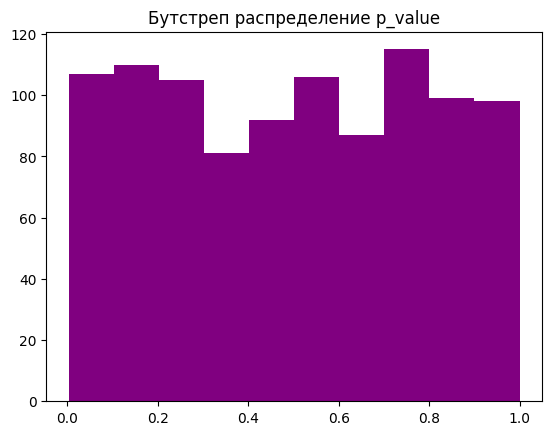

In [68]:
correctness = count_correctness(week, ttest_test, metric='total_dur_ln')
print(f'Correctness: {correctness}')

❗️Корректность 95%: в 95% тест не нашел отклонения там, где их нет. Распределение p-values менее равномерное, чем для других тестов.

In [28]:
effect=0.01
power = count_power(week, ttest_test, effect=effect, metric='total_dur_ln')
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.01
Power: 0.202


In [29]:
effect=0.03
power = count_power(week, ttest_test, effect=effect, metric='total_dur_ln')
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.03
Power: 0.899


In [30]:
effect=0.05
power = count_power(week, ttest_test, effect=effect, metric='total_dur_ln')
print(f'Effect: {effect}\nPower: {power}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Effect: 0.05
Power: 1.0


❗️Мощность 100%: тест всегда обнаруживает эффект, если он действительно существует.

In [69]:
get_mde(week['total_dur'], alpha=0.05, beta=0)

inf

❗️ У варианта бутстреп + нелогарифмированная метрика просмотра самое высокое значение корректности (96%) и самое равномерное распределение p-values. Возьмем ее для A/B теста.

# A/B тест

❓Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (2 балла)

In [48]:
ab_df = week.copy()

In [49]:
ab_df["total_dur"] = ab_df["total_dur"].apply(lambda x: x if x >= 500 else 0)

❓Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (1 балла)

In [79]:
groups_df = groups_splitter(ab_df, columns=['user_id', 'total_dur', 'group'], user_salt='kiontestmodel20210805').drop_duplicates()

❓Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (2 балла)

In [80]:
total_dur_th = groups_df.total_dur.quantile(0.9)
total_dur_th

48338.600000000035

In [84]:
def add_effect(row, th, effect=0.025):
    if row.group == 'B' and row.total_dur >= th:
        return row.total_dur * (1 + effect)
    return row.total_dur

In [52]:
groups_df.total_dur = groups_df.apply(lambda x: add_effect(x, total_dur_th), axis=1)

In [53]:
groups_df['total_dur_ln'] = np.log2(groups_df['total_dur'] + 1)

❓ Посчитайте результат такого теста и сделайте выводы

In [70]:
result = bootstrap_test(
    groups_df[groups_df['group'] == 'A']['total_dur'].values,
    groups_df[groups_df['group'] == 'B']['total_dur'].values
)

In [71]:
result

(False, 0.29)

❗️p-value очено высокое, **тест не выявил значимых отклонений между группами A и Б❗️**. Для этого теста мы получили MDE=2.53, то есть минимальный детектируемый эффект чуть больше, чем эффект который мы добавили для теста. 
Кроме того, эффект распространился не на всех пользователей, а всего на 10%, поэтому на всю выборку он значимо не повлиял.